In [358]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [359]:
# I had to convert the excel spreadsheet into csv, panda read_csv was having encoding issues
df = pd.read_csv('Credit Card Customer Data.csv')

In [360]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [361]:
df.shape

(660, 7)

In [362]:
#Lets verify the data types we will be working with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [363]:
# Verify if we have any nulls of missing values
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [364]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


In [365]:
pd.value_counts(df['Sl_No'])

660    1
226    1
224    1
223    1
222    1
      ..
440    1
439    1
438    1
437    1
1      1
Name: Sl_No, Length: 660, dtype: int64

In [366]:
df.drop('Sl_No', axis=1, inplace=True)

In [367]:
# We have several duplicate customer keys
pd.value_counts(df['Customer Key'])

47437    2
37252    2
97935    2
96929    2
50706    2
        ..
66706    1
72339    1
69965    1
85645    1
71681    1
Name: Customer Key, Length: 655, dtype: int64

In [368]:
df[df['Customer Key'] == 37252]

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,37252,6000,4,0,2,8
432,37252,59000,6,2,1,2


In [369]:
# Lets aggregate and sum the duplicate customer keys
df = df.groupby('Customer Key').agg({'Avg_Credit_Limit':'sum', 
                             'Total_Credit_Cards': 'sum', 
                             'Total_visits_bank': 'sum',
                             'Total_visits_online': 'sum',
                             'Total_calls_made': 'sum'}).reset_index();

In [370]:
# Lets get rid of the Customer Key because we do not need it as it is a unique id at this point
df.drop('Customer Key', axis=1, inplace=True)

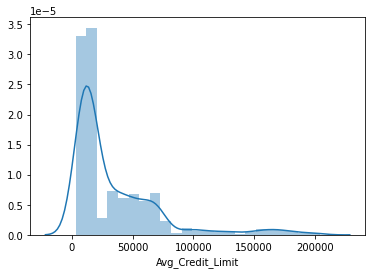

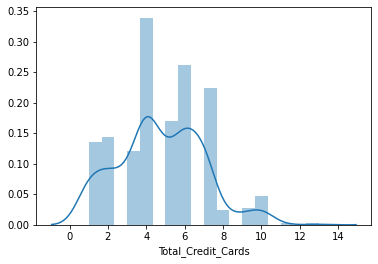

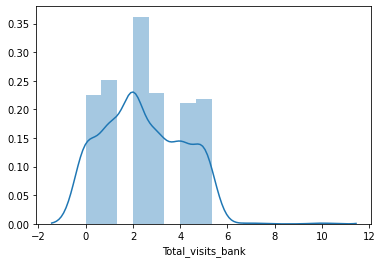

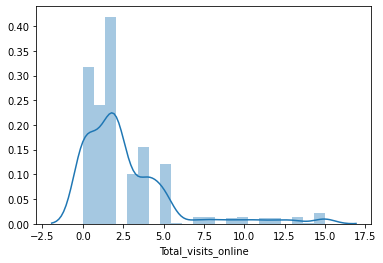

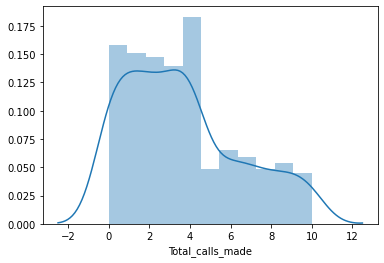

In [371]:
for i in df.columns:
    sns.distplot(df[i])
    plt.show()

Avg credit limit, total visits online and total calls made are positively skewed
Total credit cards and total visits to the bank are more normalized.

Based on the univariate analysis theres not enough clarity to make a decision se we need to standarize the data. Lets see if theres any relation between the columns

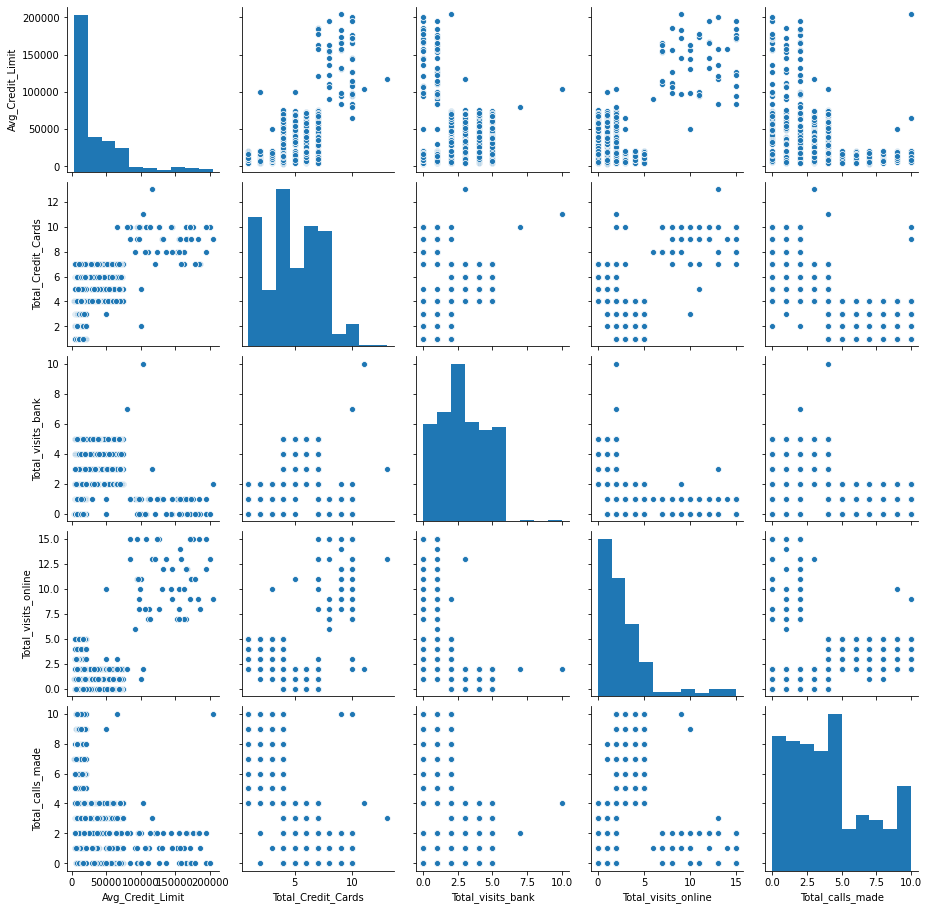

In [372]:
sns.pairplot(df);

Here we can observe that clients that have an average credit limit below 100,000 visit less online than clients with average credit limit above 100,000 visit more online.

We can observe that clients that have an average credit limit above 100,000 visit the bank less than the clients who have an average credit limit less than 100,000 visit the bank more.

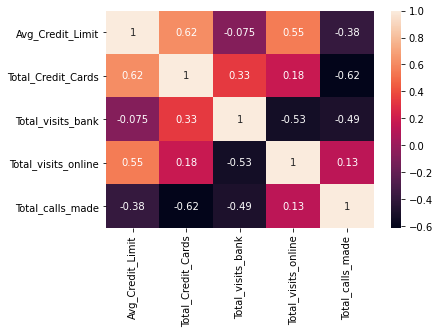

In [373]:
sns.heatmap(df.corr(), annot=True);

We can see that theres a strong relation between the average credit limit and the total credit cards and visits online. 
We can also see theres some relation between the total credit cards and the total visits to the bank.

In [375]:
df_new = df.apply(zscore)

In [376]:
df_new

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,0.425632,1.013786,0.349269,-0.212165,-1.259182
1,-0.601457,0.564814,1.556504,-0.212165,-0.910444
2,-0.417108,-1.231075,-0.254349,0.126782,0.135768
3,-0.680464,1.013786,1.556504,-0.890059,-1.259182
4,0.083269,-0.333130,0.349269,-0.212165,-1.259182
...,...,...,...,...,...
650,0.109604,0.564814,0.952887,-0.890059,0.135768
651,0.504639,0.115842,0.952887,-0.212165,-0.910444
652,-0.390772,-1.231075,-0.254349,0.465728,1.530718
653,-0.469779,-1.680047,-1.461584,0.804675,0.484505


In [377]:
cluster_range = range(1,15)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans(num_clusters, n_init = 5)
    clusters.fit(df_new)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,3275.000000
1,2,2053.104789
2,3,959.221513
3,4,808.064935
4,5,733.295936
5,6,681.105715
6,7,636.646470
7,8,614.755127
8,9,575.307391
9,10,542.195985


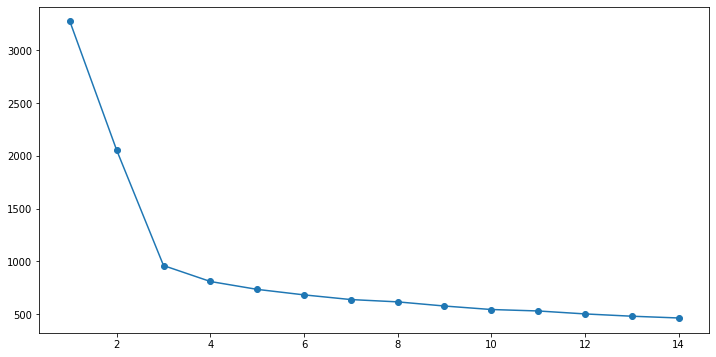

In [378]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [379]:
# Lets create 4 custers because of the bend at 
kmeans = KMeans(n_clusters=4, n_init = 5, random_state=12345)
kmeans.fit(df_new)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=12345, tol=0.0001, verbose=0)

In [380]:
# Verify the number of data on each cluster
labels = kmeans.labels_
counts = np.bincount(labels[labels>=0])
print(counts)

[189  50 197 219]


In [381]:
# Verify the centers in each group
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_new) )
centroid_df.transpose()

,0,1,2,3
Avg_Credit_Limit,-0.081433,2.814798,0.027255,-0.596887
Total_Credit_Cards,0.358144,1.875812,0.355142,-1.056816
Total_visits_bank,1.285036,-1.051124,0.033672,-0.899310
Total_visits_online,-0.542145,2.824798,-0.559715,0.326435
Total_calls_made,-0.576468,-0.812798,-0.517451,1.148540


In [382]:
k_clust_df = df.copy()

# Add clusters to the original data
predictions = kmeans.predict(df_new)
predictions
k_clust_df["group"] = predictions
k_clust_df['group'] = k_clust_df['group'].astype('category')
k_clust_df.dtypes

Avg_Credit_Limit          int64
Total_Credit_Cards        int64
Total_visits_bank         int64
Total_visits_online       int64
Total_calls_made          int64
group                  category
dtype: object

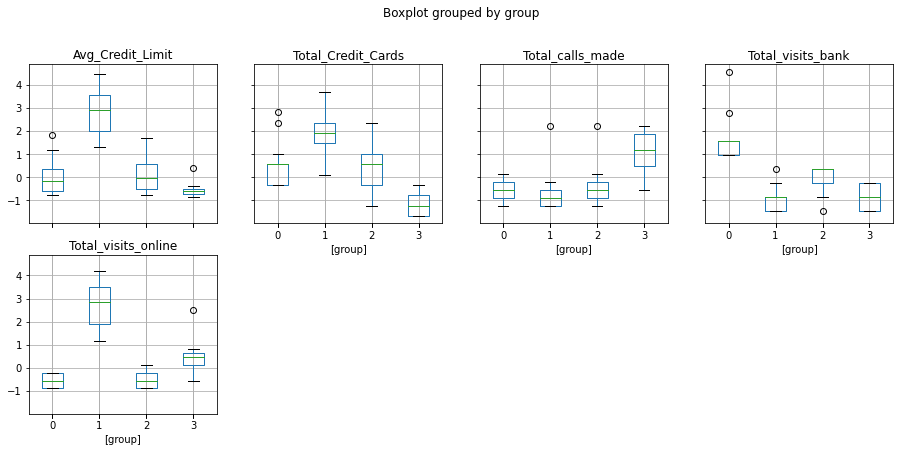

In [383]:
df_new["group"] = predictions
df_new.boxplot(by = 'group',  layout=(3,4), figsize=(15, 10));

#### Group 0 - Highest visits to the bank, low avg credit limit, low calls made, low online visits.
#### Group 1 - Highest avg credit limit, highest total credit cards, highest visits online, lowest calls made, lowest bank visits.
#### Group 2 - Low on every category
#### Group 3 - Highest Calls made, Lowest credit limit, lowest credit cards, low visits to bank and online.

In [395]:
df_new_sc = df.apply(zscore)
sc = StandardScaler()
X_std = pd.DataFrame(sc.fit_transform(df_new_sc),columns=df_new_sc.columns)

In [396]:
X_std.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,0.425632,1.013786,0.349269,-0.212165,-1.259182
1,-0.601457,0.564814,1.556504,-0.212165,-0.910444
2,-0.417108,-1.231075,-0.254349,0.126782,0.135768
3,-0.680464,1.013786,1.556504,-0.890059,-1.259182
4,0.083269,-0.333130,0.349269,-0.212165,-1.259182


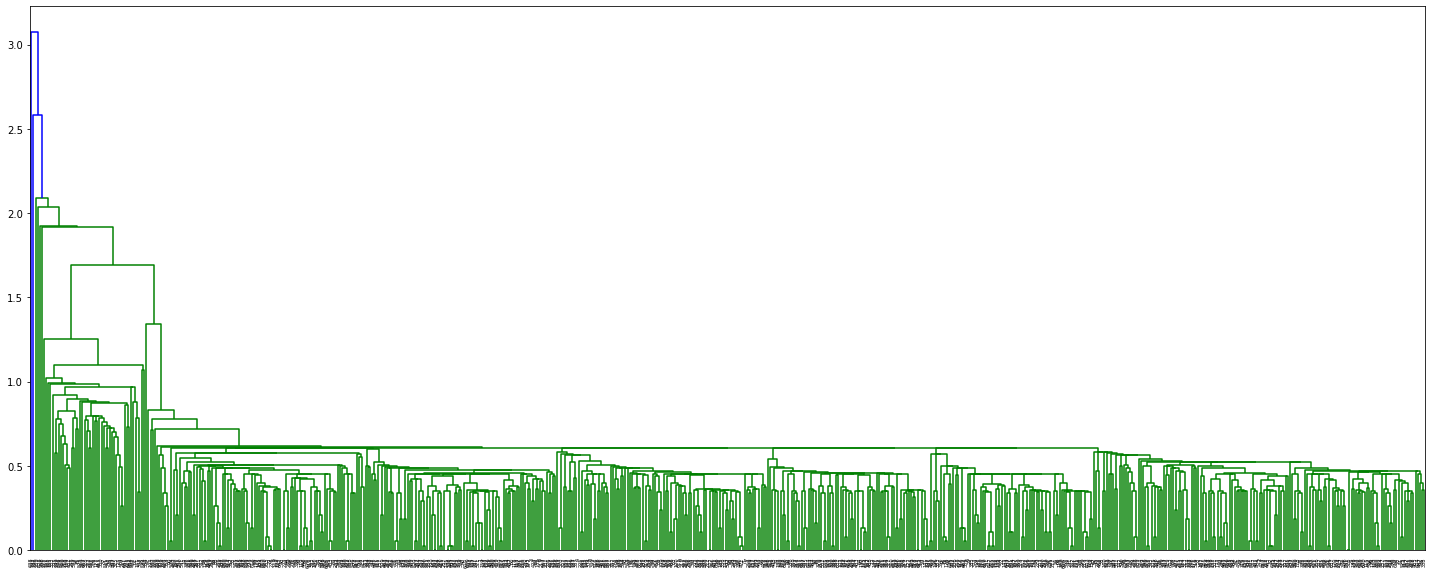

single 0.7296666486419277


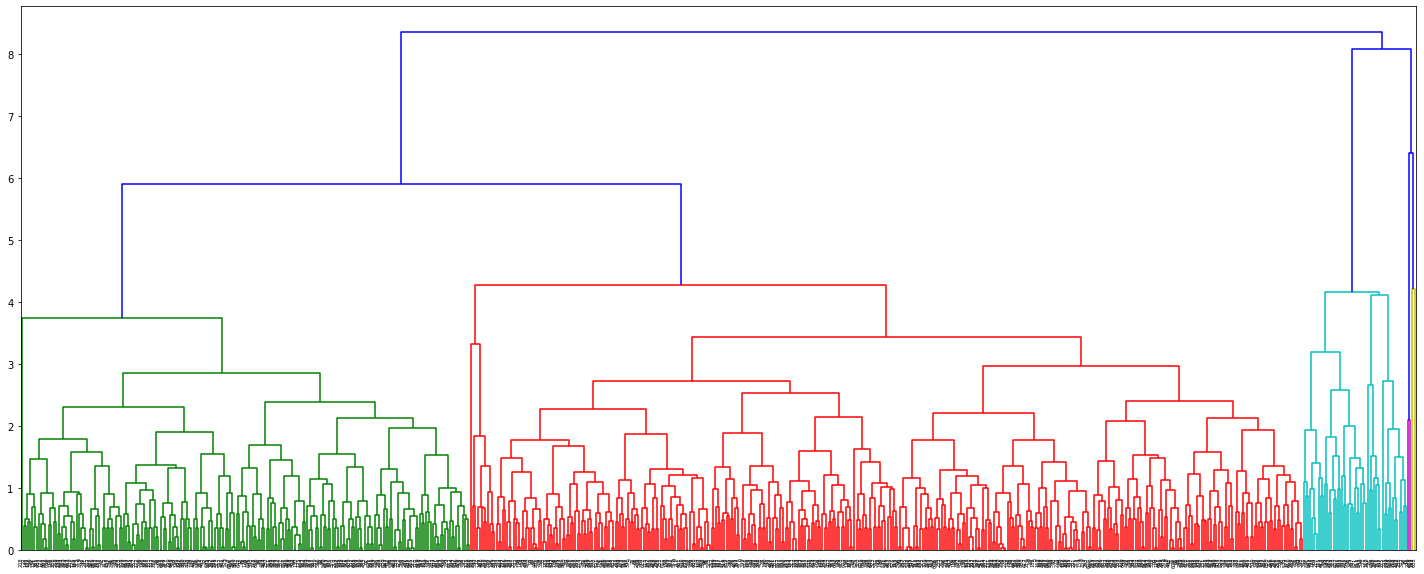

complete 0.8754561919596836


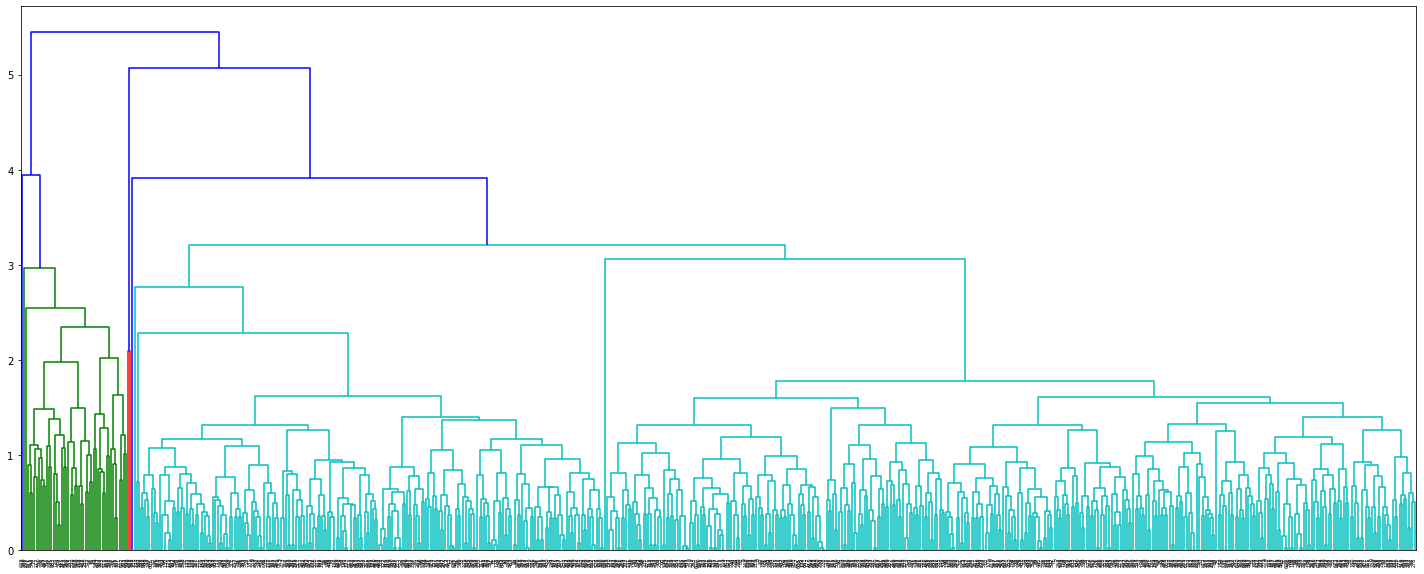

average 0.8979771743691038


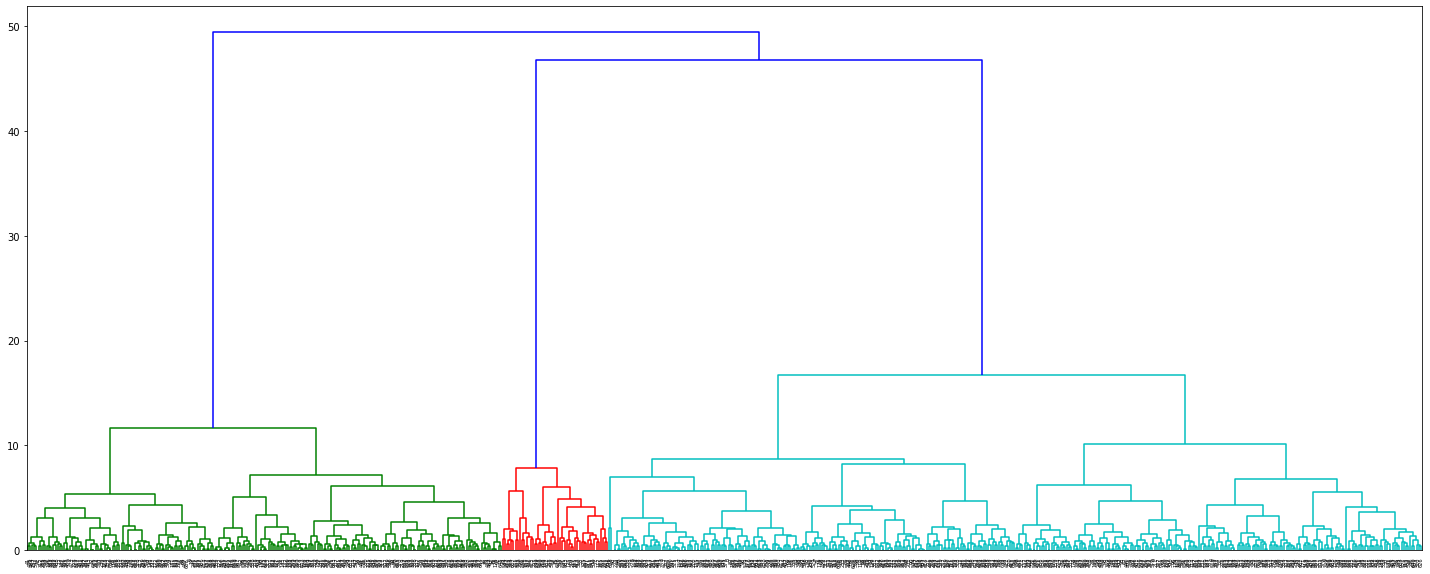

ward 0.72837138696318


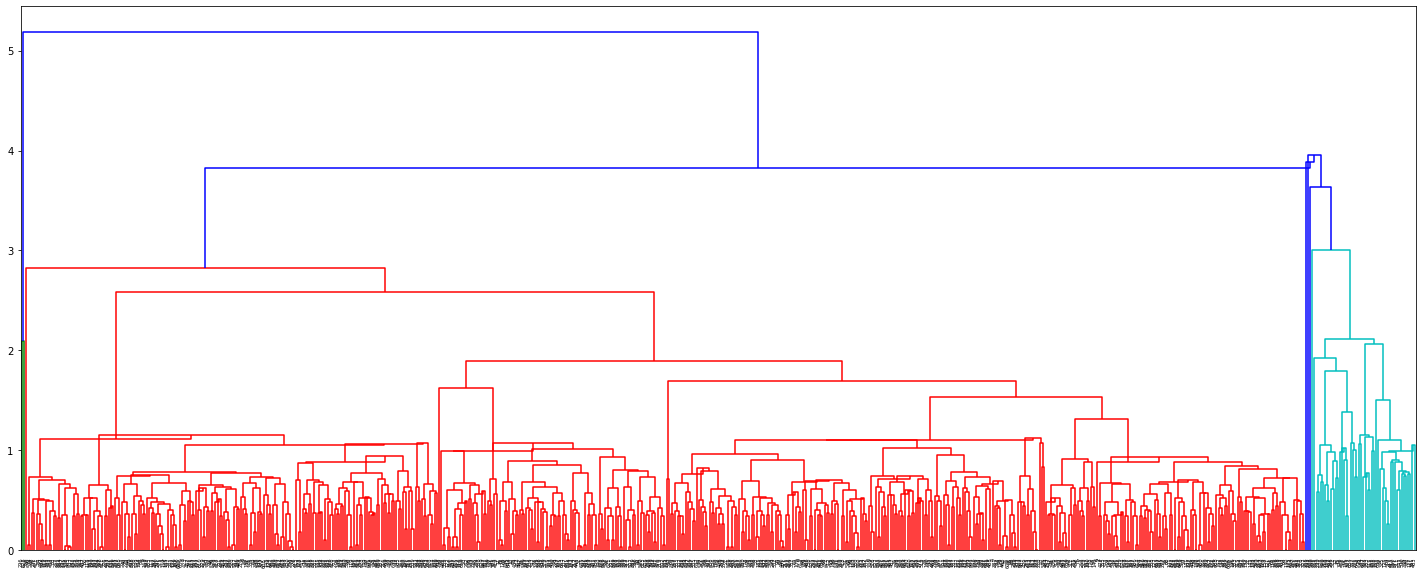

median 0.7420082911784209


In [404]:
links=['single','complete','average','ward','median']
for each in links:
    Z = linkage(X_std, method=each, metric='euclidean')
    plt.figure(figsize=(25, 10))
    dendrogram(Z)
    plt.show()
    cc,cophn_dist=cophenet(Z,pdist(X_std))
    print (each, cc)

{1, 2, 3, 4}

cluster_label
1    652
2      1
3      1
4      1
dtype: int64

0.292166228926209


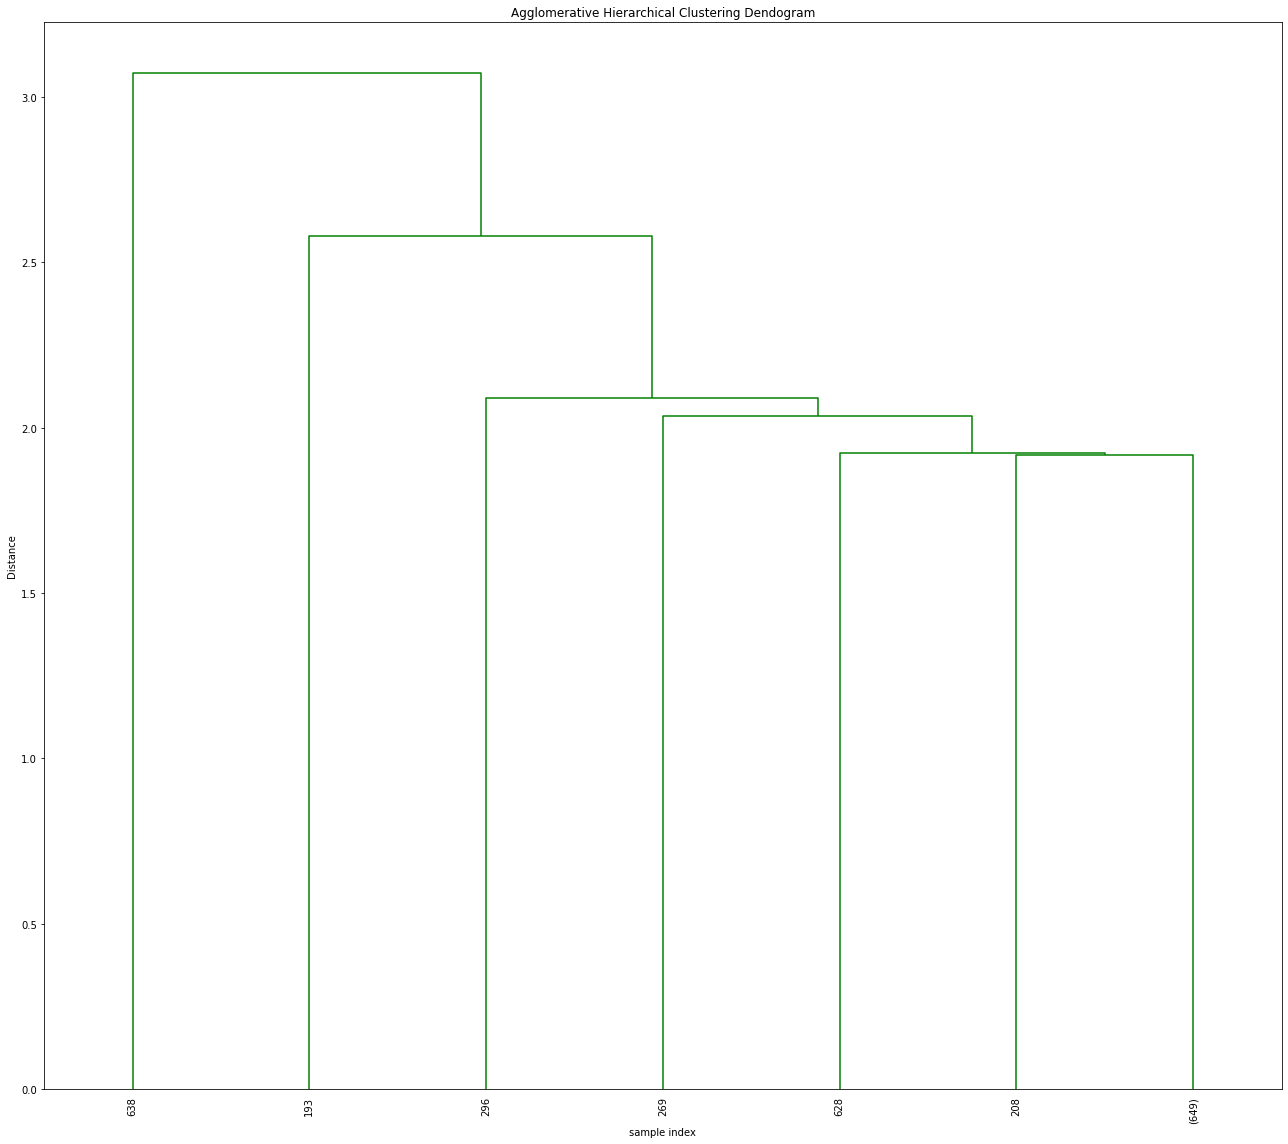

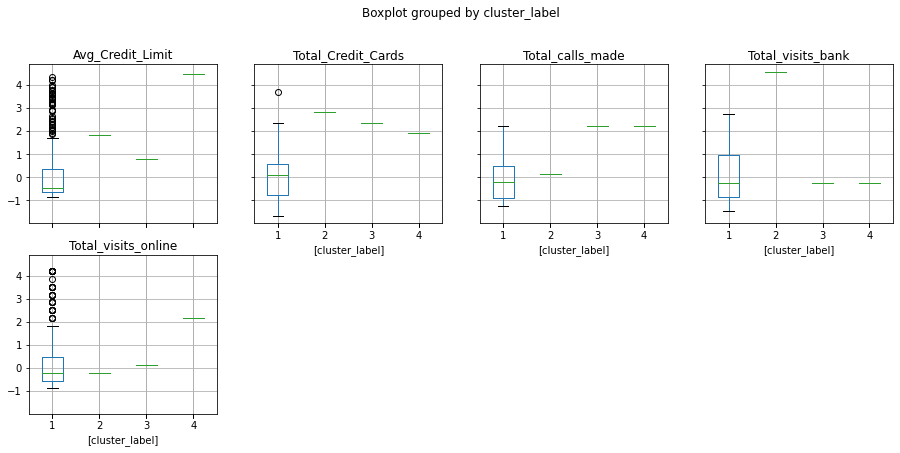

In [399]:
Z = linkage(X_std, method='single', metric='euclidean')
max_d = 2.05
clusters = fcluster(Z, max_d, criterion='distance')
df_new_sc['cluster_label'] = clusters
print(set(clusters))
print()
print(df_new_sc.groupby(['cluster_label']).size())
print()
print(silhouette_score(X_std,clusters))

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,leaf_rotation=90.0,p=5,color_threshold=52,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()
df_new_sc.boxplot(by = 'cluster_label',  layout=(3,4), figsize=(15, 10));

{1, 2, 3, 4}

cluster_label
1    602
2     49
3      2
4      2
dtype: int64

0.4829323723049531


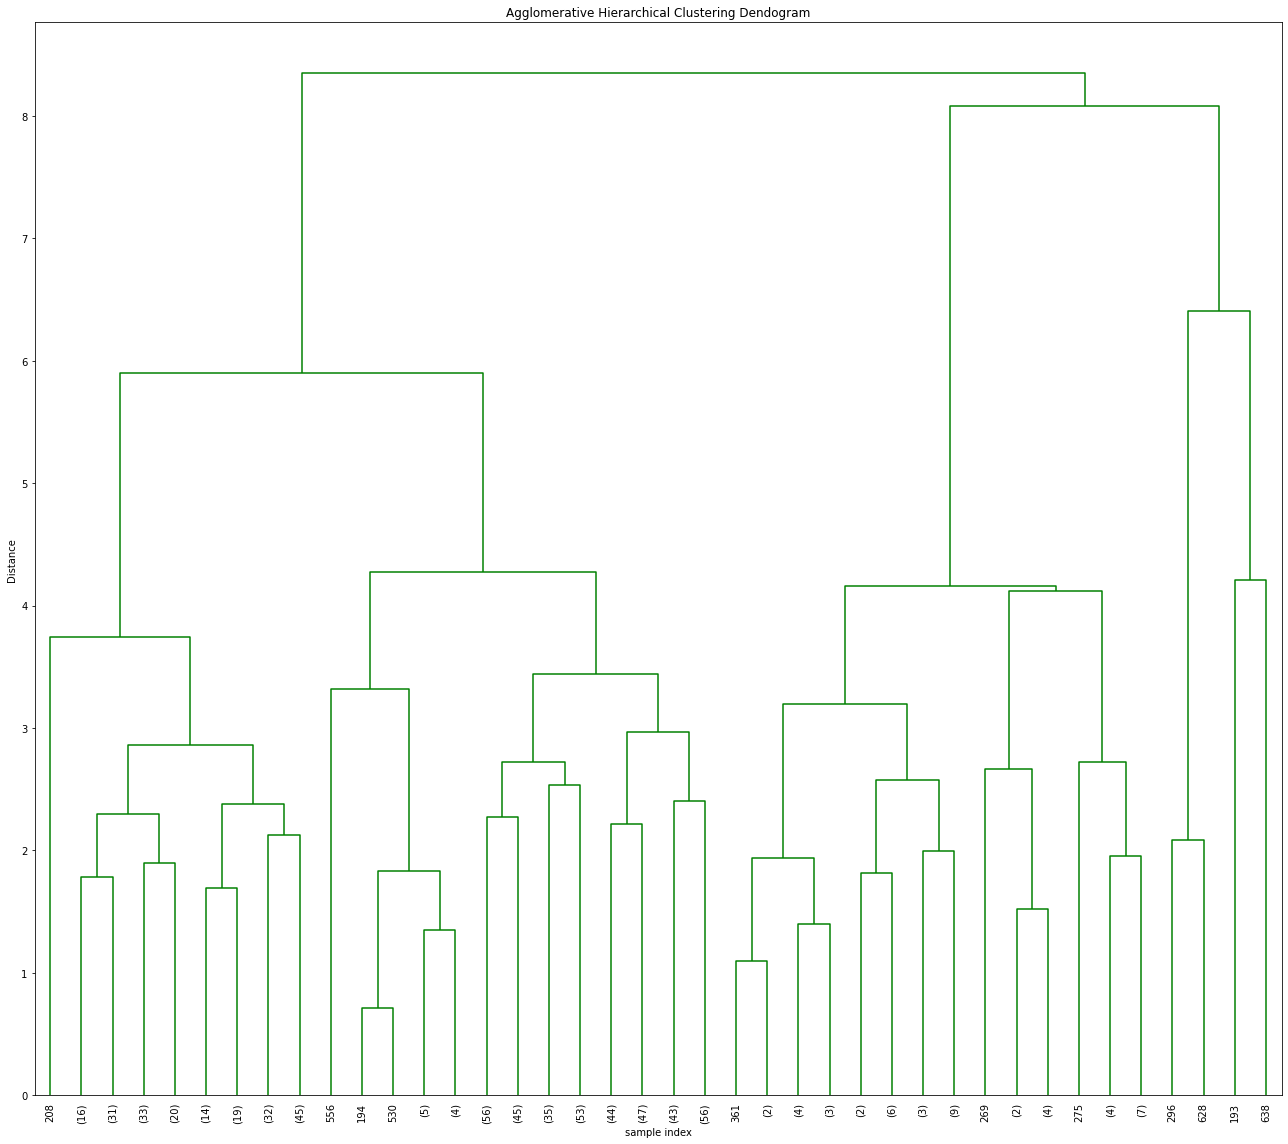

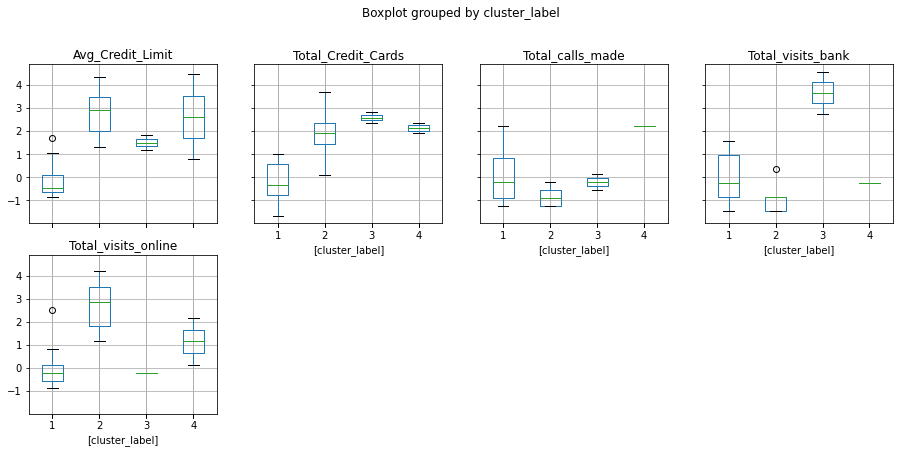

In [400]:
Z = linkage(X_std, method='complete', metric='euclidean')
max_d = 6.3
clusters = fcluster(Z, max_d, criterion='distance')
df_new_sc['cluster_label'] = clusters
print(set(clusters))
print()
print(df_new_sc.groupby(['cluster_label']).size())
print()
print(silhouette_score(X_std,clusters))

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,leaf_rotation=90.0,p=5,color_threshold=52,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()
df_new_sc.boxplot(by = 'cluster_label',  layout=(3,4), figsize=(15, 10));

{1, 2, 3, 4}

cluster_label
1     49
2      1
3      2
4    603
dtype: int64

0.4972965674766922


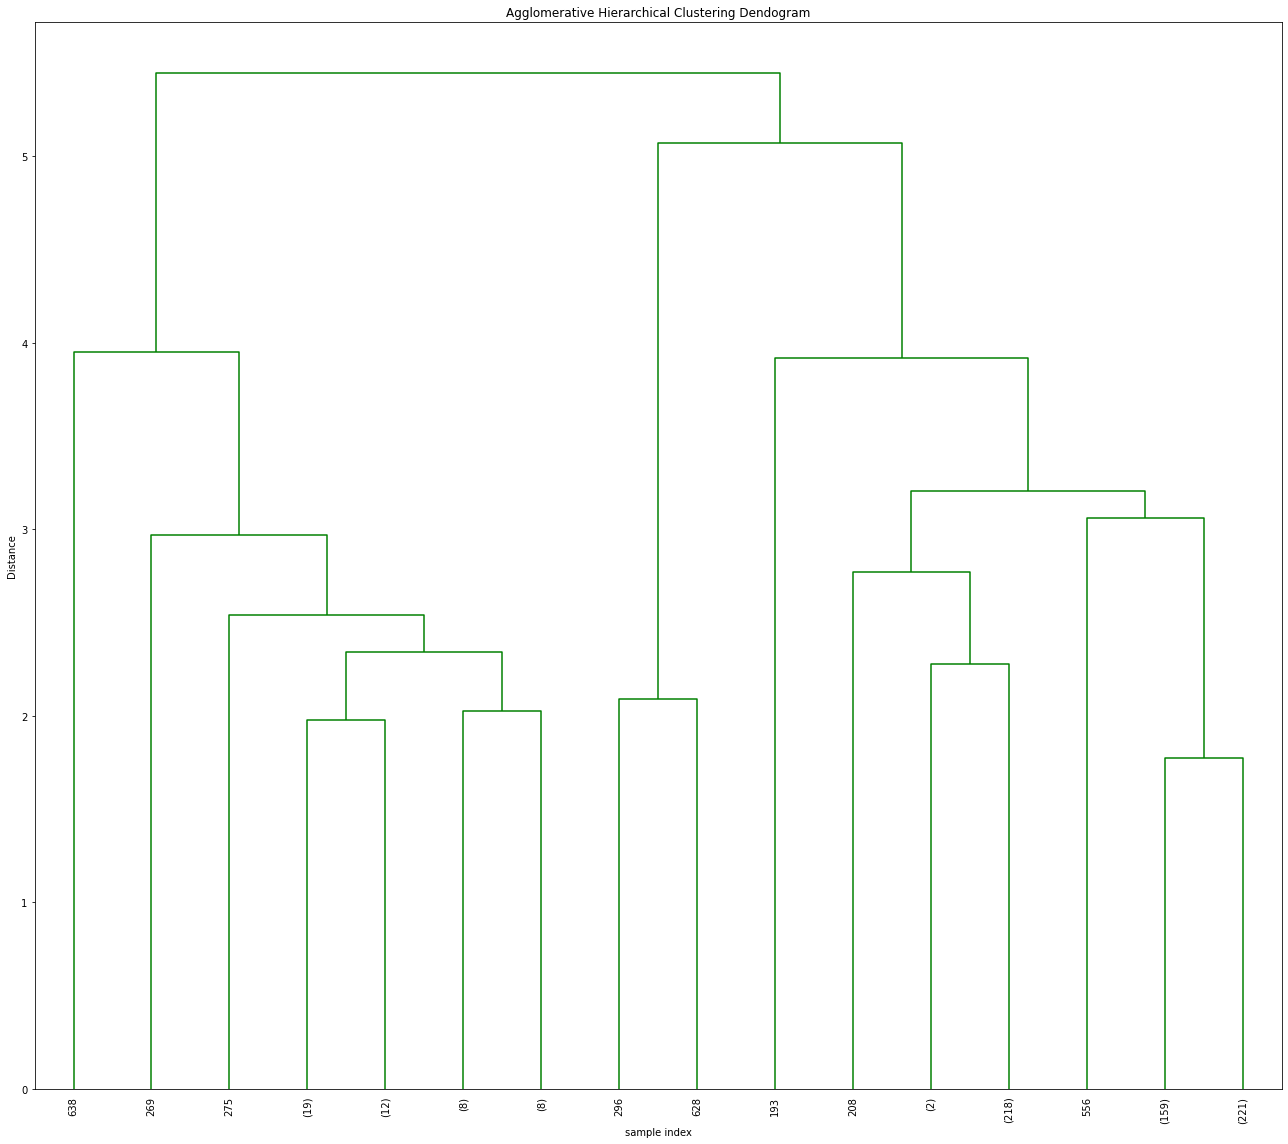

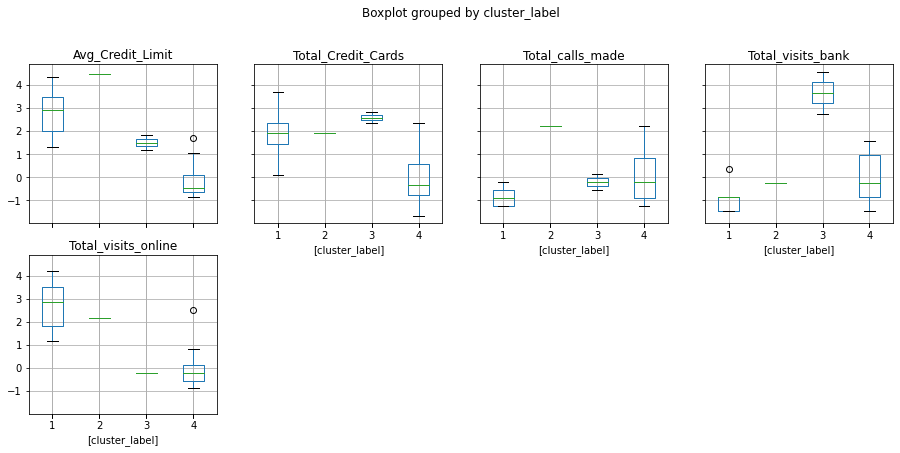

In [401]:
Z = linkage(X_std, method='average', metric='euclidean')
max_d = 3.94
clusters = fcluster(Z, max_d, criterion='distance')
df_new_sc['cluster_label'] = clusters
print(set(clusters))
print()
print(df_new_sc.groupby(['cluster_label']).size())
print()
print(silhouette_score(X_std,clusters))

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,leaf_rotation=90.0,p=5,color_threshold=52,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()
df_new_sc.boxplot(by = 'cluster_label',  layout=(3,4), figsize=(15, 10));

{1, 2, 3, 4}

cluster_label
1    223
2     50
3    191
4    191
dtype: int64

0.3450125561992108


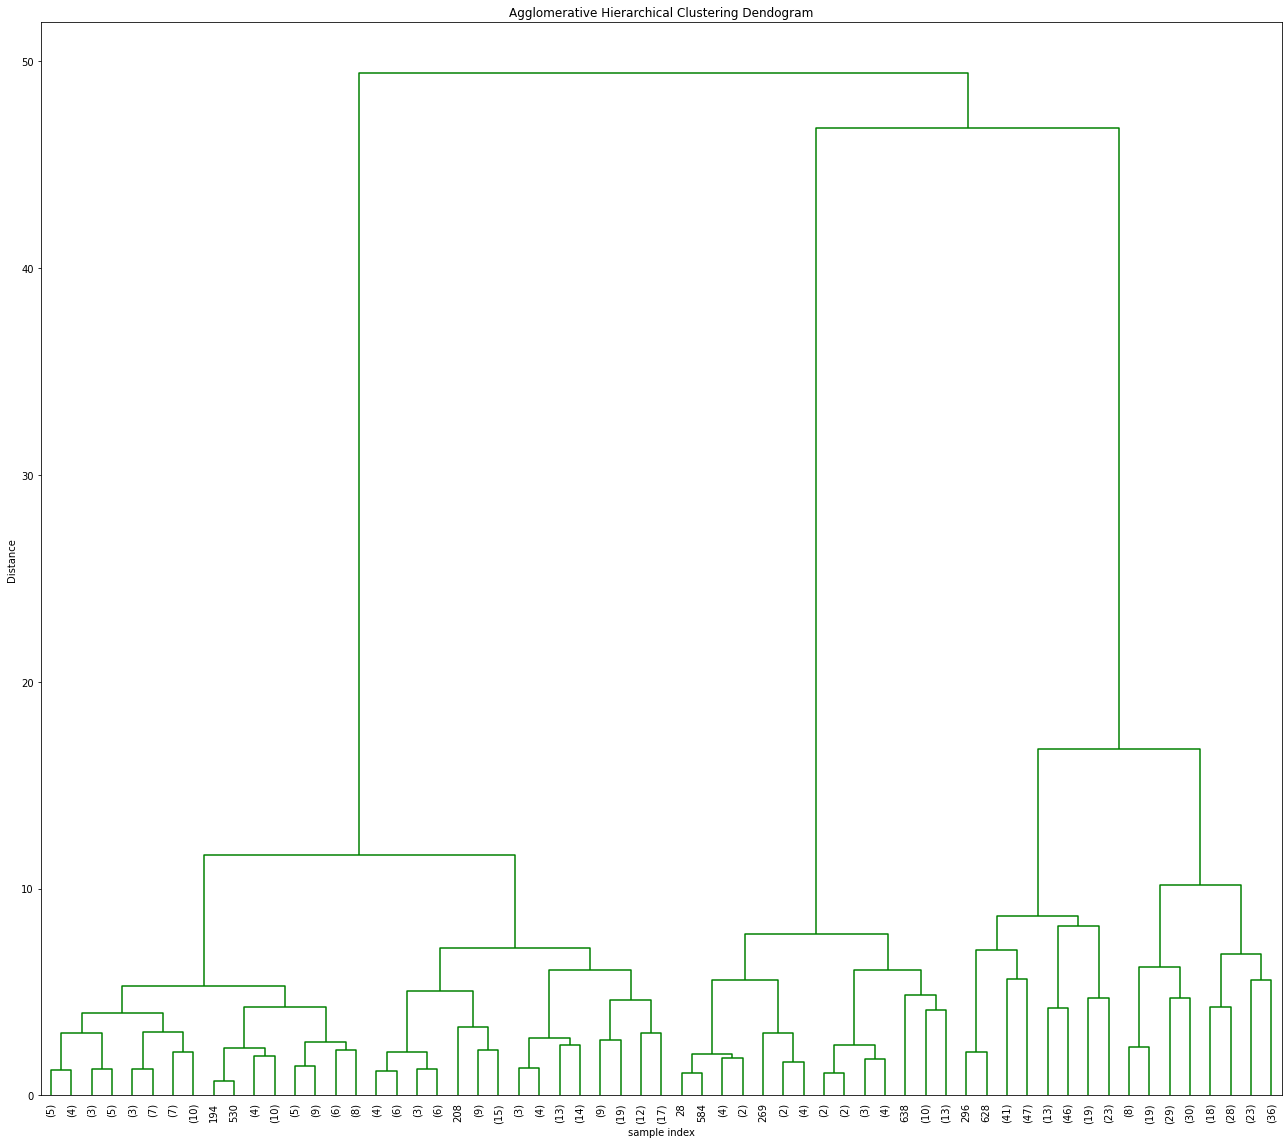

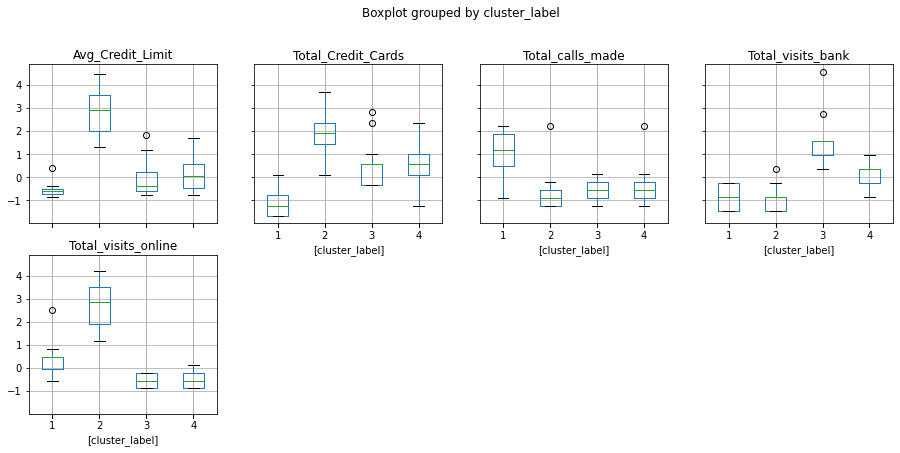

In [402]:
Z = linkage(X_std, method='ward', metric='euclidean')
max_d = 11.65
clusters = fcluster(Z, max_d, criterion='distance')
df_new_sc['cluster_label'] = clusters
print(set(clusters))
print()
print(df_new_sc.groupby(['cluster_label']).size())
print()
print(silhouette_score(X_std,clusters))

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,leaf_rotation=90.0,p=5,color_threshold=52,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()
df_new_sc.boxplot(by = 'cluster_label',  layout=(3,4), figsize=(15, 10));

{1, 2, 3, 4, 5}

cluster_label
1      2
2    601
3     50
4      1
5      1
dtype: int64

0.2985449739210557


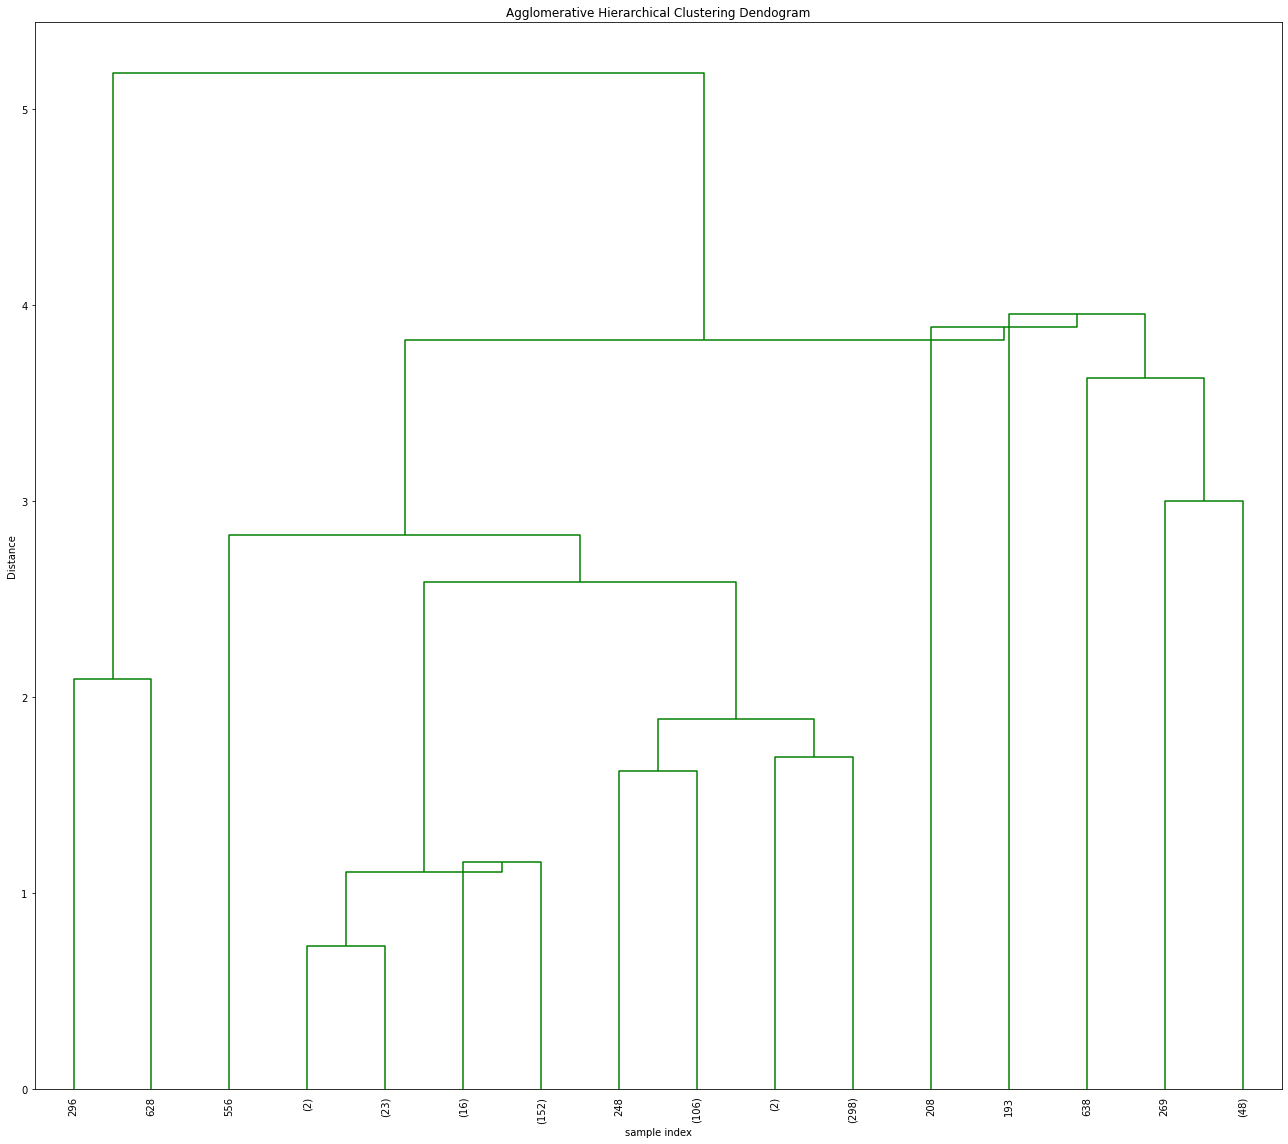

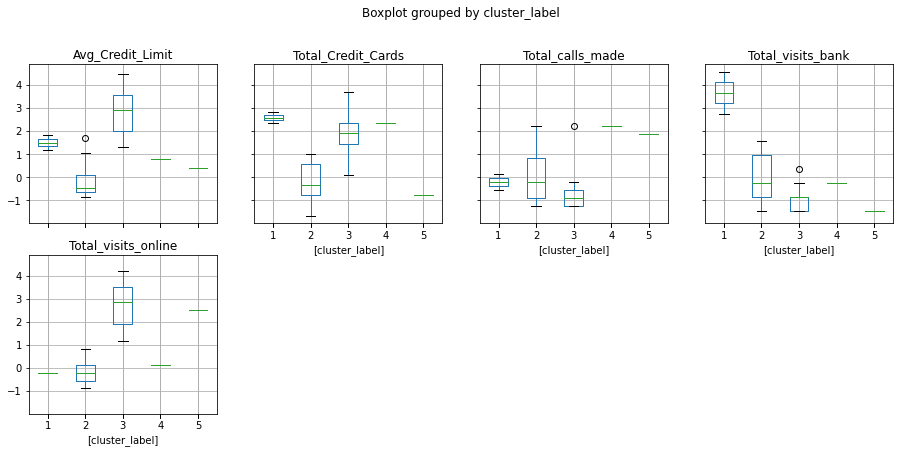

In [419]:
Z = linkage(X_std, method='median', metric='euclidean')
max_d = 3.95538
clusters = fcluster(Z, max_d, criterion='distance')
df_new_sc['cluster_label'] = clusters
print(set(clusters))
print()
print(df_new_sc.groupby(['cluster_label']).size())
print()
print(silhouette_score(X_std,clusters))

plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z,leaf_rotation=90.0,p=5,color_threshold=52,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()
df_new_sc.boxplot(by = 'cluster_label',  layout=(3,4), figsize=(15, 10));

We have seen that K Means clustering works better with large sets of data. Because our data in this excecise is pretty small bot K Means and Hierarchical work well but as analyzed and send based on our project we see that K Means its easier to work with.

## Conclusion
### How many different segments of customers are there?
There are 4 different segments of customers based on the K Clustering and Hierarchical clustering.
### How are these segments different from each other?
Group 0 - Highest visits to the bank, low avg credit limit, low calls made, low online visits.
Group 1 - Highest avg credit limit, highest total credit cards, highest visits online, lowest calls made, lowest bank visits.
Group 2 - Low on every category
Group 3 - Highest Calls made, Lowest credit limit, lowest credit cards, low visits to bank and online.
### What are your recommendations to the bank on how to better market to and service these customers?
They should better service as following:
Group 0 - Target ads at the bank for their credit limit averages and improve the bank service to focus on services for this group
Group 1 - Target online ads for high avg credit customers and improve the online experience
Group 2 - This group seems not to call, visit or online activity as much as the others but its still importnant maybe make a sub group of only this group and analyze other data related to them,
Group 3 - Improve phone service for targeting this group of low limit, low credit card maybe we can get them to raise ther card limits.